# Analyzing Sentence Structure

本章的目標是回答幾個問題:

1. 如何用正規的文法來描述無限多種可能的句子?
2. 如何將句子表現為語法樹(syntax tree)?
3. parser如何自動分析句子並產生syntax tree?

語言，就是某種文法能產生出的所有句子的集合，任何句子都能畫成一棵樹，樹中的每個節點稱為constituent，也就是句子的組成單位。例如S --> NP VP，就是將constituent S拆成constituent NP及VP。

最簡單的grammar稱為**context-free grammar(CFG)**。CFG由許多規則組成，規則左邊的符號可以展開成右邊的一到多個符號。

In [2]:
import nltk
from nltk import CFG

In [3]:
# 也可以將grammar存在檔案中，透過
#    nltk.data.load('file:mygrammar.cfg')
# 來讀取
grammar1 = CFG.fromstring("""
    S -> NP VP
    VP -> V NP | V NP PP
    PP -> P NP
    V -> "saw" | "ate" | "walked"
    NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
    Det -> "a" | "an" | "the" | "my"
    N -> "man" | "dog" | "cat" | "telescope" | "park"
    P -> "in" | "on" | "by" | "with"
    """)
grammar1

<Grammar with 25 productions>

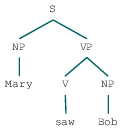

In [4]:
sent = "Mary saw Bob".split()
rd_parser = nltk.parse.RecursiveDescentParser(grammar1)
rd_parser.parse(sent).next()

使用CFG來產生syntax tree，很容易遇到**structurally ambiguous**的問題，例如"the dog saw a man in the park"，就有兩種不同的tree。在下面的例子中，稱為PP attachment ambiguous，用CFG無法判斷"in the park"是要修飾"a man"還是修飾"saw"。

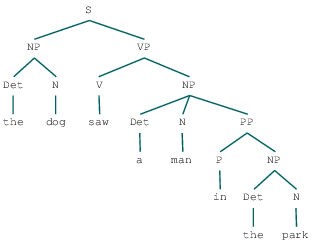

In [5]:
sent = "the dog saw a man in the park".split()
trees = rd_parser.parse(sent)
trees.next()

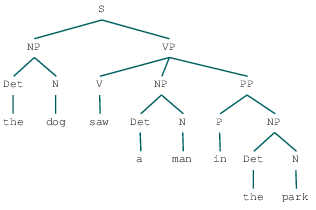

In [6]:
trees.next()

## Parsing with Context-Free Grammar

In [8]:
grammar2 = CFG.fromstring("""
    S  -> NP VP
    NP -> Det Nom | PropN
    Nom -> Adj Nom | N
    VP -> V Adj | V NP | V S | V NP PP
    PP -> P NP
    PropN -> 'Buster' | 'Chatterer' | 'Joe'
    Det -> 'the' | 'a'
    N -> 'bear' | 'squirrel' | 'tree' | 'fish' | 'log'
    Adj  -> 'angry' | 'frightened' |  'little' | 'tall'
    V ->  'chased'  | 'saw' | 'said' | 'thought' | 'was' | 'put'
    P -> 'on'
    """)

### 1. Re-cursive descent parsing

這是一種top-down的方法，從最上層的S開始，recursive嘗試所有可能的展開規則，如果展開不下去，就會backtracking到上一個狀態。如果syntax tree不是唯一解，所有可能的展開規則都會被記錄下來。

缺點:

1. 如果遇到left-recursive的規則，例如`NP -> NP PP`，會造成無窮迴圈
2. 會浪費很多時間在探索可能的規則
3. backtracking時會浪費已經展開的結果

### 2. Shift-reduce parsing

這種方法的資料結構由一個stack及一個queue組成，stack包含已經處理的token，queue則包含未處理的token。

演算法的每個循環中，有兩種動作可以選擇：shift或reduce。

* shift是將queue的第一個token移動到stack最上層
* reduce則是將stack最上層的n個token合併成一個，再push回stack最上層

在設計演算法時，要考慮什麼時候用shift或reduce，其次是reduction要用那一種規則。例如「永遠先作reduce，不能reduce時才作shift」、「reduce時優先用最多token的規則」。

優點: 每個token只會用到一次，所以不會浪費時間

缺點: 因為無法回復上一動，如果一開始的parsing有問題，可能無法產生syntax tree。

### 3. Left-corner parsing

Left-corner與recursive decent幾乎一樣，只差在展開時會查表，看下一個token是否符合table。

這種parser在開始前，會建一個表格，第一欄是所有的non-terminal，第二欄展開後的第一個non-terminal。例如`S, NP`表示所有規則都是`S -> NP ...`。例如`NP, Det PropN`表示規則有`NP -> Det ...`及`NP -> PropN ...`兩種。

### 4. Chart parsing

chart parser用dynamic programming的技巧，也就是將計算的中間結果存下來給後面用。

演算法會建一個表格，稱為WFST(well-formed substring table)。`WFST[0][2]`代表第0和第1個字的可能結果。

一開始會先從`WFST[0][1], WFST[1][2]...`開始，先嘗試找一個token對應的non-terminal。接下來嘗試將第0和1個non-terminal結合，將結果存在`WFST[0][2]`。這樣一層層往上作，直到`WFST[0][7]=S`為止。

缺點:

1. WFST不會自動變syntax tree，需要進一步解析
2. 只支援binary production
3. bottom-up可能有點浪費
4. 無法處理ambiguity的情況，最終只存在一種結果

In [14]:
groucho_grammar = CFG.fromstring("""
    S -> NP VP
    PP -> P NP
    NP -> Det N | Det N PP | 'I'
    VP -> V NP | VP PP
    Det -> 'an' | 'my'
    N -> 'elephant' | 'pajamas'
    V -> 'shot'
    P -> 'in'
    """)

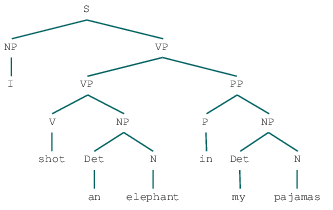

In [17]:
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']
parser = nltk.ChartParser(groucho_grammar)
trees = parser.parse(sent)
trees.next()

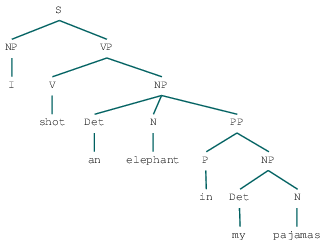

In [18]:
trees.next()

## Dependency Grammar

dependency grammar的焦點放在字和字之間的關係，通常這種關係是不對稱的，一個字稱為**head**，另一個則稱為**dependent**。

例如"I shot an elephant"，這裡面有幾個關係:

* `shot -> I`(主詞)
* `shot -> elephant`(受詞)
* `elephant -> an`(冠詞)

如果把dependency畫成一個graph，如果graph的edge都沒有交叉，稱為**projective**。